# Data augmentation
In this tutorial I will explore data augmentation, which is a technique to increase the diversity of a training dataset by applying random transformations. It is akin of bootstrapping. 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

c:\Users\xtomma\Anaconda3\envs\machinelearning\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...: 100%|██████████| 1/1 [00:08<00:00,  8.67s/ url]


Dataset tf_flowers downloaded and prepared to C:\Users\xtomma\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


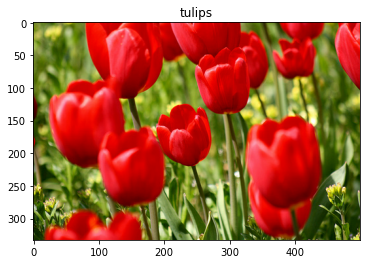

In [4]:
num_classes = metadata.features['label'].num_classes
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

## Preprocessing
We want to resize images to a consistent shape, and rescale pixel values:

In [6]:
IMG_SIZE = 180
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1./255)
])


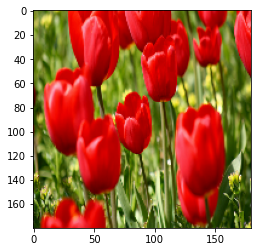

In [7]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

## Data augmentation
Let's start with the technique. We use methods such as layers.RandomFlip or layers.RandomRotation. 
Let's create a few preprocessing layers and apply them repeatedly to the same image.

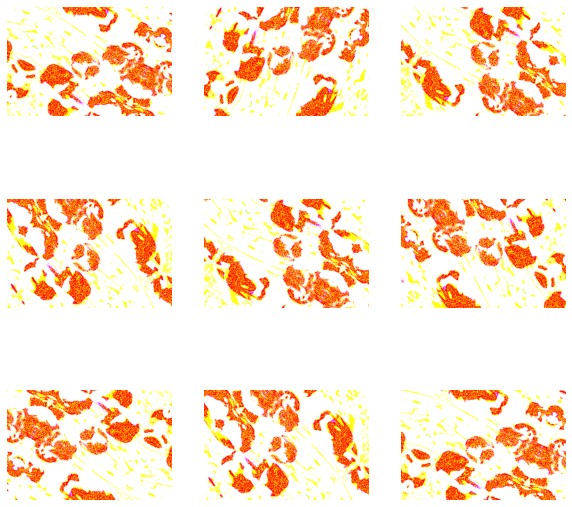

In [8]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

image = tf.cast(tf.expand_dims(image, 0), tf.float32)

plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

### Options to use the Keras preprocessing layers:
1. Make the preprocessing layers part of your model
2. Apply preprocessing layers to the dataset

There are important trade-offs here. In option 1, data augmentation will run on-device, and thus it will benefit from GPU acceleration. In addition, when you export the model, the preprocessing will be saved along with the rest of the model. If the model is deployed later, it will automatically standardize images (otherwise this has to be done server side). In option 2, data augmentation will happen asynchronously, and is non-blocking. You can overlap the training of your model on the GPU with data processing, as shown below. 

We will show option 2 here.

## Apply preprocessing layers to datasets


In [9]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
                num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    ds = ds.batch(batch_size)

    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)

    return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)